In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# to make torch.use_deterministic_algorithms(True) work
os.environ.update({'CUBLAS_WORKSPACE_CONFIG': ':4096:8'})

In [3]:
from pathlib import Path

import pandas as pd
import torch

from src.augmentations import DefaultWaveAugmentations, DefaultWave2Spec
from src.configs import DefaultConfig, DistillationConfig
from src.data_utils import get_dataloaders, SpeechCommandsDataset
from src.models import CRNN
from src.trainers import DefaultTrainer, DistillationTrainer
from src.utils import count_parameters, seed_all

In [12]:
CHECKPOINT_DIR = Path('checkpoints')
DATA_DIR = Path('data/speech_commands')
TRAIN_CSV = Path('data/train.csv')
VAL_CSV = Path('data/val.csv')

In [5]:
train_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(TRAIN_CSV))
train_set.transforms = DefaultWaveAugmentations(DATA_DIR)

val_set = SpeechCommandsDataset(DATA_DIR, csv=pd.read_csv(VAL_CSV))
train_loader, val_loader = get_dataloaders(train_set, val_set, DefaultConfig.batch_size)

train_wave2spec = DefaultWave2Spec(is_train=True, config=DefaultConfig)
val_wave2spec = DefaultWave2Spec(is_train=False, config=DefaultConfig)

In [6]:
teacher_config = DefaultConfig()
student_config = DistillationConfig(
    num_epochs=30,
    hidden_size=32,
)

In [7]:
teacher = CRNN(teacher_config)
teacher.load_state_dict(torch.load(CHECKPOINT_DIR / 'baseline.pth',
                        map_location=teacher_config.device))
teacher = teacher.eval()
print('teacher total:', count_parameters(teacher))
print('teacher conv:', count_parameters(teacher.conv))
print('teacher gru:', count_parameters(teacher.gru))
print('teacher attention:', count_parameters(teacher.attention), end='\n\n')

student = CRNN(student_config)
student = student.train()
print('student total:', count_parameters(student))
print('student conv:', count_parameters(student.conv))
print('student gru:', count_parameters(student.gru))
print('student attention:', count_parameters(student.attention))

teacher total: 70443
teacher conv: 808
teacher gru: 65280
teacher attention: 4225

student total: 25387
student conv: 808
student gru: 23424
student attention: 1089


Проверим, что модель учителя воспроизводит нужное качество на валидации:

In [ ]:
seed_all()
DefaultTrainer(
    opt=None,
    train_loader=None,
    val_loader=val_loader,
    device=teacher_config.device,
    model=teacher,
    train_wave2spec=None,
    val_wave2spec=val_wave2spec,
).validation()

100%|██████████| 102/102 [00:07<00:00, 12.78it/s]


1.71149264626571e-05

Теперь сделаем дистилляцию:

In [ ]:
opt = torch.optim.Adam(
    student.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

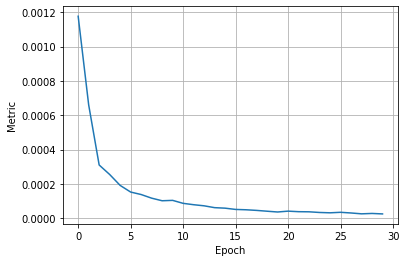

END OF EPOCH 30


[0.0011762036282390916,
 0.0006606821115749386,
 0.0003103333606348635,
 0.00025506790248609523,
 0.00019144191017617543,
 0.00015279905581462174,
 0.0001383933959537939,
 0.00011721456958839288,
 0.00010211965798194549,
 0.00010438434228898117,
 8.707248675614705e-05,
 7.911476205672125e-05,
 7.266981066910978e-05,
 6.194612766583405e-05,
 5.899517538696936e-05,
 5.16192865767029e-05,
 4.9614190589446e-05,
 4.599487298149568e-05,
 4.122381869038886e-05,
 3.6691466302526904e-05,
 4.164154702106738e-05,
 3.850858454097848e-05,
 3.7792478831243875e-05,
 3.390760535593363e-05,
 3.195621729690683e-05,
 3.4901202028190404e-05,
 3.095068552948782e-05,
 2.601253990610959e-05,
 2.8220532511124627e-05,
 2.5511265909295366e-05]

In [ ]:
seed_all()
trainer = DistillationTrainer(
    opt=opt,
    train_loader=train_loader,
    val_loader=val_loader,
    device=student_config.device,
    teacher=teacher,
    student=student,
    train_wave2spec=train_wave2spec,
    val_wave2spec=val_wave2spec,
    temp=student_config.temp,
    alpha=student_config.alpha,
)
trainer.train(n_epochs=student_config.num_epochs)

In [ ]:
torch.save(trainer.best_state, CHECKPOINT_DIR / 'distillated_hs32.pth')

In [ ]:
trainer.best_score

2.5511265909295366e-05

Теперь попробуем еще уменьшить `hidden_size`:

In [ ]:
student_config = DistillationConfig(
    num_epochs=30,
    hidden_size=16,
)
student = CRNN(student_config)
student = student.train()
opt = torch.optim.Adam(
    student.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

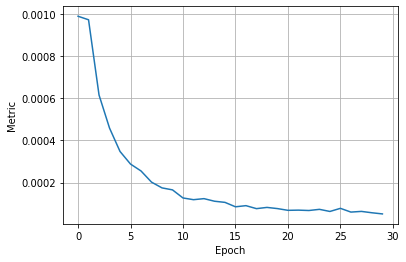

END OF EPOCH 30


[0.0009902787158016632,
 0.0009735218421938732,
 0.0006159255047165259,
 0.0004587880418104286,
 0.00034768125717131383,
 0.00028779393342096677,
 0.0002550410485219801,
 0.00020198059920443638,
 0.00017461044222362158,
 0.0001651727657240776,
 0.00012672385665891034,
 0.00011855428402035471,
 0.00012352823492921966,
 0.0001112589571024334,
 0.0001057777646491731,
 8.4789899806368e-05,
 9.017262772453979e-05,
 7.601163731453795e-05,
 8.186281771782779e-05,
 7.624735544399225e-05,
 6.798230204413867e-05,
 6.889235305025974e-05,
 6.716176425173442e-05,
 7.266384312152867e-05,
 6.263836318524416e-05,
 7.74408649602166e-05,
 5.9639670525730496e-05,
 6.288601640986071e-05,
 5.641421105813421e-05,
 5.0938986152455024e-05]

In [ ]:
seed_all()
trainer = DistillationTrainer(
    opt=opt,
    train_loader=train_loader,
    val_loader=val_loader,
    device=student_config.device,
    teacher=teacher,
    student=student,
    train_wave2spec=train_wave2spec,
    val_wave2spec=val_wave2spec,
    temp=student_config.temp,
    alpha=student_config.alpha,
)
trainer.train(n_epochs=student_config.num_epochs)

In [ ]:
trainer.best_score

5.0938986152455024e-05

Как мы видим, даже так получается приемлемое качество. Но если посмотреть на график, то возникает подозрение, что модель недообучилась. Давайте сделаем еще 10 эпох:

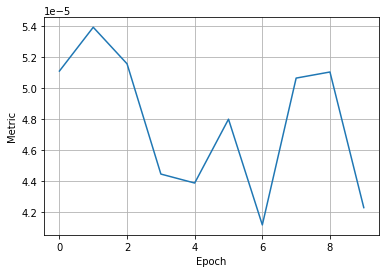

END OF EPOCH 10


[5.1106077484726434e-05,
 5.3934695038178137e-05,
 5.1574529969844476e-05,
 4.445822947935684e-05,
 4.3879377363988024e-05,
 4.799996896875258e-05,
 4.1176078309739884e-05,
 5.065254386856118e-05,
 5.1046402008915224e-05,
 4.2292009707409655e-05]

In [ ]:
seed_all()
trainer = DistillationTrainer(
    opt=opt,
    train_loader=train_loader,
    val_loader=val_loader,
    device=student_config.device,
    teacher=teacher,
    student=student,
    train_wave2spec=train_wave2spec,
    val_wave2spec=val_wave2spec,
    temp=student_config.temp,
    alpha=student_config.alpha,
)
trainer.train(n_epochs=10)

In [ ]:
torch.save(trainer.best_state, CHECKPOINT_DIR / 'distillated_hs16.pth')

In [ ]:
trainer.best_score

4.1176078309739884e-05

Теперь попробуем еще уменьшить сверточную сеть:

In [9]:
student_config = DistillationConfig(
    num_epochs=50,
    hidden_size=16,
    cnn_out_channels=4,
    stride=(5, 10),
    kernel_size=(10, 20),
)
student = CRNN(student_config)
student = student.train()
opt = torch.optim.Adam(
    student.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

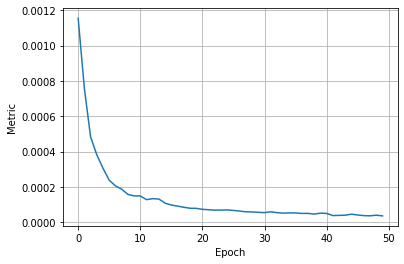

END OF EPOCH 50


[0.0011556364755007556,
 0.0007572698529491842,
 0.00048278951818170015,
 0.00038144862515909105,
 0.00030467612552796013,
 0.00023687881745883618,
 0.0002054179066111625,
 0.00018639933247012753,
 0.00015711657648956329,
 0.0001482279143674825,
 0.0001481831577606241,
 0.0001270699744186154,
 0.00013276003103721495,
 0.00013032228785032674,
 0.00010720699229485176,
 9.650121193431938e-05,
 9.031584886648672e-05,
 8.399323220428823e-05,
 7.830914313326982e-05,
 7.776012875580661e-05,
 7.225506611222184e-05,
 6.983224179428641e-05,
 6.767795711750146e-05,
 6.788980505663129e-05,
 6.894307720469927e-05,
 6.567882867782568e-05,
 6.244143411506714e-05,
 5.809705947601053e-05,
 5.730039187393078e-05,
 5.525352305360604e-05,
 5.344833991031671e-05,
 5.81298809877067e-05,
 5.3349875375228196e-05,
 5.061972235686502e-05,
 5.1738637528325336e-05,
 5.1822183194461045e-05,
 4.89428414865698e-05,
 4.9277024151112624e-05,
 4.517433518909144e-05,
 5.048843631008034e-05,
 4.8945825260360374e-05,
 3.6

In [10]:
seed_all()
trainer = DistillationTrainer(
    opt=opt,
    train_loader=train_loader,
    val_loader=val_loader,
    device=student_config.device,
    teacher=teacher,
    student=student,
    train_wave2spec=train_wave2spec,
    val_wave2spec=val_wave2spec,
    temp=student_config.temp,
    alpha=student_config.alpha,
)
trainer.train(n_epochs=student_config.num_epochs)

In [13]:
torch.save(trainer.best_state, CHECKPOINT_DIR / 'distillated_hs16_c4.pth')

In [14]:
trainer.best_score

3.4814672588264125e-05